# Analysis of XCO2 and SIF

Resolution: global, monthly

Findings: In terms of maximizing the correlation coefficient between detrended SIF and XCO2, the optimal time lag is 4 months (though similar results are obtained at 3 months).

---

In [1]:
import numpy as np
import pandas as pd
import xarray

import statsmodels.api as sm
from sklearn.linear_model import LinearRegression

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
DS_sif = xarray.open_dataset("../data/exp_pro/OCO2_Lite_SIF740.nc")
DS_xco2 = xarray.open_dataset("../data/exp_pro/OCO2_Lite_XCO2_land.nc")

In [3]:
# Compute monthly climatologies
df_sif_monthly = DS_sif.sif.resample(time="1MS").mean(dim="time").to_dataframe()
df_xco2_monthly = DS_xco2.xco2.resample(time="1MS").mean(dim="time").to_dataframe()
df_monthly = pd.merge(df_sif_monthly, df_xco2_monthly, how="outer", on=["time"]).reset_index()

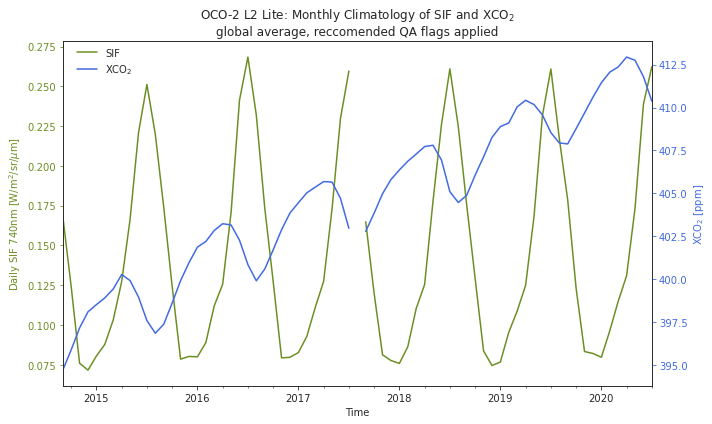

In [5]:
# Plot global monthly climatology
sns.set_style("ticks")
fig, ax1 = plt.subplots(figsize=(10,6))
ax2 = ax1.twinx()

# Set variable colors
sif_color = "olivedrab"
xco2_color = "royalblue"

# Line plots
df_monthly.plot(x="time", y="sif", color=sif_color, ax=ax1, legend=False, label="SIF")
df_monthly.plot(x="time", y="xco2", color=xco2_color, ax=ax2, legend=False, label="XCO$_2$")

# Customize axes
# plt.locator_params(axis="x", nbins=8)
ax1.tick_params(axis="y", colors=sif_color)
ax2.tick_params(axis="y", colors=xco2_color)
ax1.yaxis.label.set_color(sif_color)
ax2.yaxis.label.set_color(xco2_color)
ax1.figure.legend(loc="upper left", bbox_to_anchor=(0.1, 0.9), frameon=False)

# Add titles
ax1.set_xlabel("Time")
ax1.set_ylabel("Daily SIF 740nm [W/m$^2$/sr/$\mu$m]")
ax2.set_ylabel("XCO$_2$ [ppm]")
ax1.set_title("OCO-2 L2 Lite: Monthly Climatology of SIF and XCO$_2$\n"
              "global average, reccomended QA flags applied")

plt.tight_layout()
plt.savefig("../plots/monthly_climatology_comparison.png")

In [6]:
## Create a dataframe of SIF residuals and XCO2 residuals lagged by 0-4 months

# Interpolate missing values
df_monthly_interp = df_monthly.interpolate().set_index("time")

# Fit trends by least squares
X = (df_monthly_interp.index - df_monthly_interp.index[0]).days.values.reshape(-1, 1)
trend_sif = LinearRegression().fit(X, df_monthly_interp.sif).predict(X)
trend_xco2 = LinearRegression().fit(X, df_monthly_interp.xco2).predict(X)

# Remove trends
df_monthly_interp["sif_anom"] = df_monthly_interp.sif - trend_sif
df_monthly_interp["xco2_anom_lag0"] = df_monthly_interp.xco2 - trend_xco2

# Apply monthly lag
for t in range(1, 5):
    df_monthly_interp[f"xco2_anom_lag{t}"] = df_monthly_interp.xco2_anom_lag0.shift(t)
    
df_monthly_interp

,sif,xco2,sif_anom,xco2_anom_lag0,xco2_anom_lag1,xco2_anom_lag2,xco2_anom_lag3,xco2_anom_lag4
time,,,,,,,,
2014-09-01,0.168572,394.688568,0.035291,-2.421934,NaN,NaN,NaN,NaN
2014-10-01,0.124161,395.870636,-0.009437,-1.450876,-2.421934,NaN,NaN,NaN
2014-11-01,0.075926,397.148132,-0.057999,-0.391424,-1.450876,-2.421934,NaN,NaN
2014-12-01,0.071579,398.089172,-0.062663,0.338606,-0.391424,-1.450876,-2.421934,NaN
2015-01-01,0.080472,398.510010,-0.054098,0.541399,0.338606,-0.391424,-1.450876,-2.421934
...,...,...,...,...,...,...,...,...
2020-03-01,0.114833,412.368561,-0.039666,1.134431,1.035856,0.633936,0.011404,-0.699400
2020-04-01,0.130919,412.945526,-0.023908,1.493352,1.134431,1.035856,0.633936,0.011404
2020-05-01,0.173319,412.756134,0.018175,1.092950,1.493352,1.134431,1.035856,0.633936


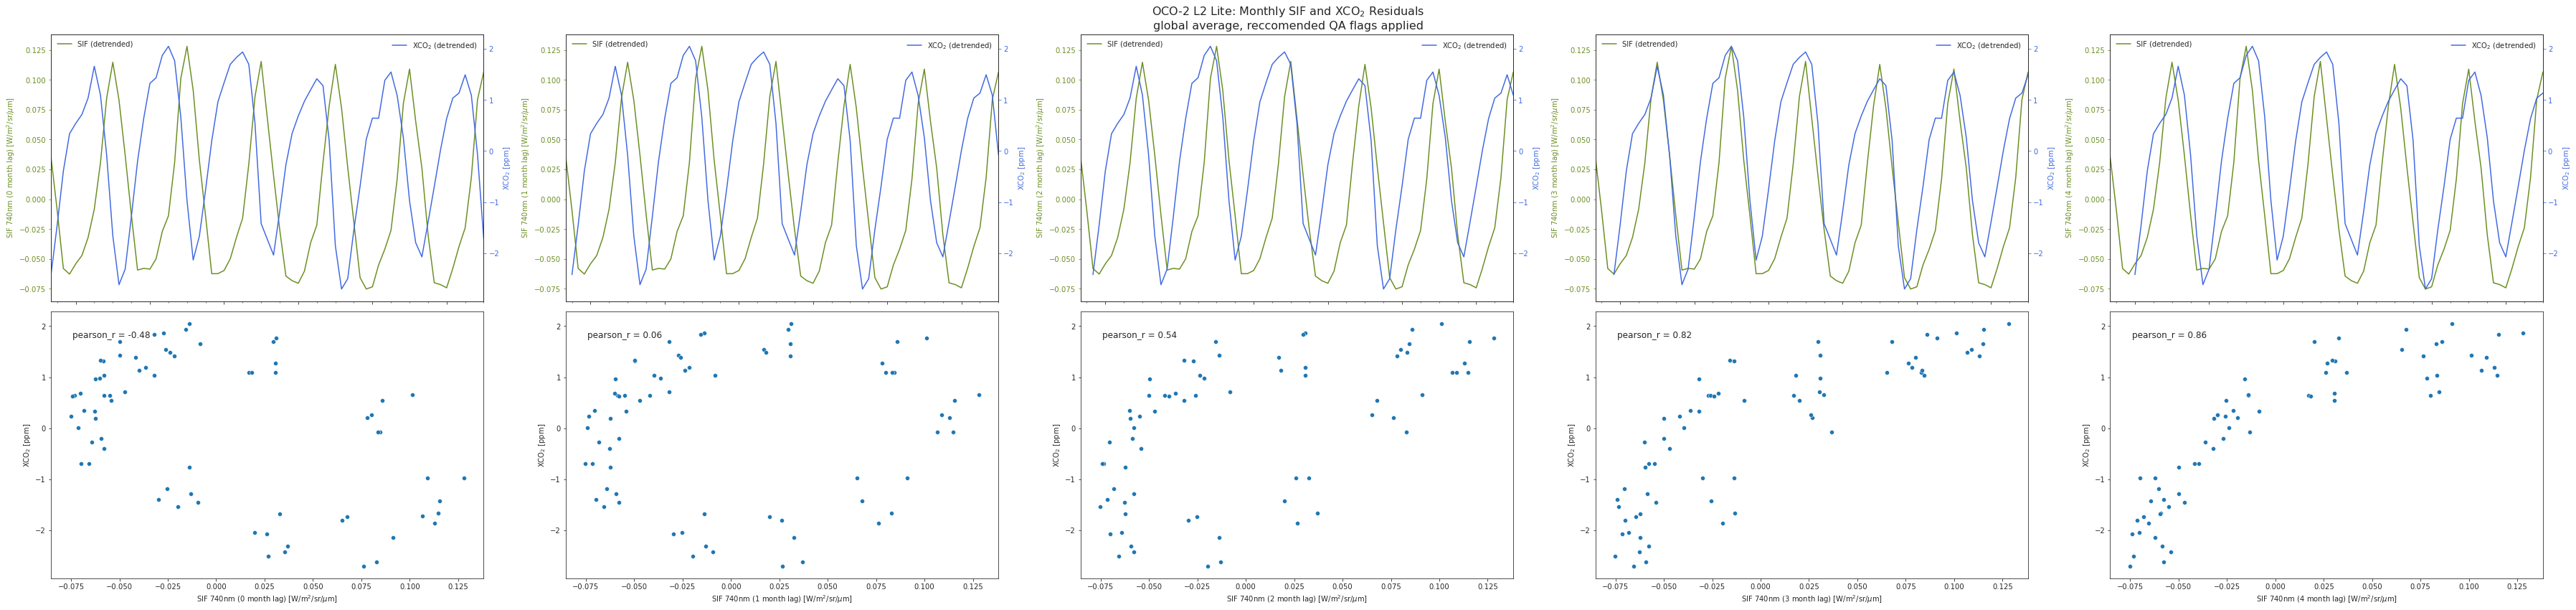

In [7]:
## Create grid of figures with timeseries on top row and scatter plots on bottom
fig, axes = plt.subplots(2, 5, figsize=(50, 12))
fig.subplots_adjust(top=0.85)
fig.suptitle("OCO-2 L2 Lite: Monthly SIF and XCO$_2$ Residuals\n"
             "global average, reccomended QA flags applied",
             size=16)

sif_color = "olivedrab"
xco2_color = "royalblue"

# Time series
for j in range(5):
    ax1 = axes[0, j]
    ax2 = ax1.twinx()
    
    df_monthly_interp.plot(y="sif_anom", use_index=True, color=sif_color, ax=ax1, legend=False, label="SIF (detrended)")
    df_monthly_interp.plot(y=f"xco2_anom_lag{j}", use_index=True, color=xco2_color, ax=ax2, legend=False, label="XCO$_2$ (detrended)")

    # Customize axes
    ax1.tick_params(axis="y", colors=sif_color)
    ax2.tick_params(axis="y", colors=xco2_color)
    ax1.yaxis.label.set_color(sif_color)
    ax2.yaxis.label.set_color(xco2_color)
    ax1.legend(loc="upper left", frameon=False)
    ax2.legend(loc="upper right", frameon=False)

    # Add titles
    ax1.set_xlabel("Time")
    ax1.set_ylabel(f"SIF 740nm ({j} month lag) [W/m$^2$/sr/$\mu$m]")
    ax2.set_ylabel("XCO$_2$ [ppm]")
    
    
# Scatterplots
for j in range(5):
    pearson_corr = df_monthly_interp.sif_anom.corr(df_monthly_interp[f"xco2_anom_lag{j}"])
    sns.scatterplot(x="sif_anom", y=f"xco2_anom_lag{j}", data=df_monthly_interp, ax=axes[1, j])
    axes[1, j].annotate("pearson_r = {:.2f}".format(pearson_corr), fontsize=12,
                        xy=(0.1, 0.9), xytext=(0.05, 0.9), textcoords="axes fraction")
    axes[1, j].set_xlabel(f"SIF 740nm ({j} month lag) [W/m$^2$/sr/$\mu$m]")
    axes[1, j].set_ylabel("XCO$_2$ [ppm]")


plt.tight_layout()
plt.savefig("../plots/monthly_lagged_residual_analysis.png")